<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBM_Boost" data-toc-modified-id="LGBM_Boost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>LGBM_Boost</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Чтобы это осуществить, неоходимо разработать модель машинного обучения, которая будет классифицировать пользовательские комментарии на позитивные и негативные.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import transformers
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from tqdm import notebook
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    make_scorer,
    precision_score, 
    recall_score, 
    f1_score)

from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    RandomizedSearchCV)

from nltk.corpus import wordnet
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
df_comm = pd.read_csv('/datasets/toxic_comments.csv')

df_comm.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df_comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Количество пропусков:  Unnamed: 0    0
text          0
toxic         0
dtype: int64

Количество дубликатов  0


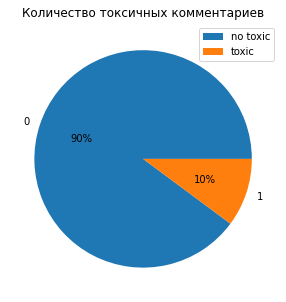

In [4]:
print('Количество пропусков: ',df_comm.isna().sum())
print('')
print('Количество дубликатов ',df_comm.duplicated().sum())
df_comm.value_counts('toxic').plot(kind = 'pie', figsize = (5,5), title = 'Количество токсичных комментариев',
                                   ylabel = '', legend = True, autopct='%1.0f%%')
plt.legend(['no toxic', 'toxic'])
plt.show()

Представлен набор данных с разметкой о токсичности правок. Общее число наблюдений 159292, 3 столбца с признаками: unnamed, text и toxic. Последний является целевым признаком. Unnamed, вероятно, содержит порядковое число, однако последние значения в нем не совпадают с индексом.Toxic содержит нативный текст (без предобработки). Пропуски и явные дубликаты не обнаружены. Классы несбалансированны: 0 -90%, 1 - 10%.

In [5]:
df_comm.loc[df_comm['Unnamed: 0'].diff() != 1, 'Unnamed: 0'].unique()

array([     0,   6084,   6609,   6859,   7209,   8787,  11671,  12525,
        14127,  15449,  18206,  18351,  19486,  24376,  25194,  25928,
        26494,  26846,  29375,  29912,  34766,  35577,  37375,  38792,
        38998,  43420,  43655,  45863,  46208,  50362,  51340,  53126,
        57485,  57895,  58402,  60493,  67129,  69570,  70507,  72220,
        73493,  74173,  74725,  82241,  83122,  84321,  88828,  89456,
        89865,  90079,  92463,  96416,  97400,  98139,  98523,  99685,
       112479, 114753, 118012, 119123, 122593, 123102, 123490, 123861,
       125798, 127403, 129312, 129913, 132571, 133024, 137547, 138276,
       138938, 141579, 142714, 143829, 144528, 151819, 155558, 156165])

Вероятно, что часть наблюдений была удалена, старые индексы сохранили в столбце Unnamed: 0. Задача сохранить этот столбец не стоит, поэтому далее его удалим. Однако стоит уточнить, почему от части данных решили избавиться. 

In [6]:
df_comm_new = df_comm.drop('Unnamed: 0', axis = 1)

df_comm_new.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = " ".join(lemmatizer.lemmatize(w, get_wordnet_pos(lemmatizer.lemmatize(w))) for w in nltk.word_tokenize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())


sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

print(df_my['text'].apply(lemmatize_text))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked
0    the strip bat be hang on their foot for best
1       you should be ashamed of yourself go work
Name: text, dtype: object


In [10]:
tqdm.pandas()
df_comm_new['lemm_text'] = df_comm_new['text'].progress_apply(lemmatize_text)

100%|██████████| 159292/159292 [20:53<00:00, 127.03it/s]


In [11]:
df_comm_new

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n t make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159290,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


In [12]:
df_comm_new = df_comm_new.drop(['text'], axis=1)

df_comm_new.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i ca n t make any real suggestion on impr...
4,0,you sir be my hero any chance you remember wha...


In [13]:
target = df_comm_new['toxic']
features = df_comm_new.drop(['toxic'], axis=1)

In [14]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)

features_train

,lemm_text
97400,bushranger you re a grass with no sense of hum...
4383,need administrative help i have be block iniqu...
103680,i d also like to point out that he ha use a th...
38573,you cant block me you fuck retard brb nigger
128311,i believe that the frequency of the wave need ...
...,...
109993,hahaha i dont live in a lie like you and dont ...
85412,march march
133249,agree we really should try to stick to the sub...
130333,umm killer do you not like that he copy your w...


In [18]:
# Загрузка стоп-слов

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words)


features_train = pd.DataFrame(features_train)
features_test = pd.DataFrame(features_test)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])


print(features_train.shape)
print(features_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(127433, 136833)
(31859, 136833)


**Вывод**

Был представлен набор данных с разметкой о токсичности правок. Общее число наблюдений 159292, 3 столбца с признаками: unnamed, text и toxic. Последний являлся целевым признаком. Unnamed, вероятно, содержал порядковое число, однако последние значения в нем не совпадали с индексом. Toxic содержал нативный текст (без предобработки). Пропуски и явные дубликаты не были обнаружены. Классы были несбалансированны: 0 -90%, 1 - 10%.

Вероятно, что часть наблюдений в столбце Unnamed была удалена, старые индексы сохранили в столбце Unnamed: 0. Задача сохранить этот столбец не стояла, поэтому далее его удалили. Однако, в дальнейшем, стоит уточнить, почему от части данных решили избавиться. Были созданы несколько выборок: обучающая и тестовая.

Была выполнена векторизация текстов, для определения тональности были применены величины TF-IDF как признаки.


## Обучение

### Логистическая регрессия

In [19]:
best_f1 = 0
best_params = {}
best_model_log = None
scores = []

for pen in ['l1', 'l2']:
    for c in range (5,15):
        model = LogisticRegression(max_iter=1000, penalty=pen, C=c, solver='liblinear')
        scoring = make_scorer(f1_score)
        scores = cross_val_score(model, features_train,target_train, cv = 2, scoring=scoring)
        final_score = abs(np.mean(scores))
        if final_score > best_f1:
            best_f1 = final_score
            best_params = {'penalty': pen, 'C': c}
            best_model_log = model

print('Best Model Hyperparameters:', best_params)
print('F1 на CV:', best_f1)

Best Model Hyperparameters: {'penalty': 'l1', 'C': 5}
F1 на CV: 0.7591217971309911


In [20]:
# добавим взвешивание классов

best_f1 = 0
best_params = {}
best_model_log_balanced = None
scores = []

for pen in ['l1', 'l2']:
    for c in range (5,15):
        model = LogisticRegression(max_iter=1000, penalty=pen, C=c, solver='liblinear', class_weight = 'balanced')
        scoring = make_scorer(f1_score)
        scores = cross_val_score(model, features_train,target_train, cv = 2, scoring=scoring)
        final_score = abs(np.mean(scores))
        if final_score > best_f1:
            best_f1 = final_score
            best_params = {'penalty': pen, 'C': c}
            best_model_log = model

print('Best Model Hyperparameters:', best_params)
print('F1 на CV:', best_f1)

Best Model Hyperparameters: {'penalty': 'l2', 'C': 7}
F1 на CV: 0.7539933595472352


F1 для модели логистической регрессии (без взвешивания классов) для кросс-валидационной выборки - 0.7591217971309911.

### Дерево решений

In [22]:
best_model_tree = None
best_result = 0
max_depth = None
scores = []

for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    scoring = make_scorer(f1_score)
    scores = cross_val_score(model, features_train,target_train, cv = 2, scoring=scoring)
    final_score = abs(np.mean(scores))       
    if final_score > best_result:
        best_result = final_score
        best_model_tree = model
        max_depth = depth        

print("F1 на CV:", best_result, 'и максимальную глубину:', max_depth)

F1 на CV: 0.6003711496390347 и максимальную глубину: 10


In [23]:
# добавим взвешивание классов

best_model_tree_balanced = None
best_result = 0
max_depth = None
scores = []

for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345, class_weight = 'balanced')
    scoring = make_scorer(f1_score)
    scores = cross_val_score(model, features_train,target_train, cv = 2, scoring=scoring)
    final_score = abs(np.mean(scores))       
    if final_score > best_result:
        best_result = final_score
        best_model_tree_balanced = model
        max_depth = depth        

print("F1 на CV:", best_result, 'и максимальную глубину:', max_depth)

F1 на CV: 0.5668563918194784 и максимальную глубину: 10


F1 для дерева решений (без взвешивания классов) для кросс-валидационной выборки - 0.6003711496390347.

### Случайный лес

In [25]:
best_model_forest = None
best_result = 0
max_depth = None
n_estimators = None
scores = []            
               
for est in range(20,41,20):
    for depth in range(1,11,1):
        model = DecisionTreeClassifier(max_depth = depth, random_state = 12345, class_weight = 'balanced')
        scoring = make_scorer(f1_score)
        scores = cross_val_score(model, features_train,target_train, cv = 2, scoring=scoring)
        final_score = abs(np.mean(scores))       
        if final_score > best_result:
            best_result = final_score
            best_model_forest = model
            max_depth = depth
            n_estimators = est
            
print("F1 на CV:", best_result,',','число деревьев:', n_estimators,' и максимальную глубину:', max_depth)

F1 на CV: 0.5668563918194784 , число деревьев: 20  и максимальную глубину: 10


F1 для случайного леса для кросс-валидационной выборки - 0.5668563918194784.

### CatBoost

In [26]:
model_cat = CatBoostClassifier(iterations=250, random_state=12345, verbose= 100)

train_f1 = cross_val_score(model_cat, 
                       features_train, 
                       target_train, 
                       cv=2, 
                       scoring='f1').mean()

print('F1 на CV', train_f1)

Learning rate set to 0.21649
0:	learn: 0.4990019	total: 1.58s	remaining: 6m 33s
100:	learn: 0.1383931	total: 1m 47s	remaining: 2m 39s
200:	learn: 0.1169059	total: 3m 35s	remaining: 52.4s
249:	learn: 0.1098941	total: 4m 27s	remaining: 0us
Learning rate set to 0.216491
0:	learn: 0.4962071	total: 1.55s	remaining: 6m 25s
100:	learn: 0.1393009	total: 1m 49s	remaining: 2m 41s
200:	learn: 0.1169520	total: 3m 36s	remaining: 52.7s
249:	learn: 0.1101894	total: 4m 28s	remaining: 0us
F1 на CV 0.7263386773408648


F1 для CatBoost для кросс-валидационной выборки - 0.7263386773408648.

### LGBM_Boost

In [28]:
param_grid = {
    'max_depth': [1, 4, 7],
    'n_estimators': [20, 40, 60]
}

model_lgbm = LGBMClassifier(verbose=100, random_state=12345)

random_search = RandomizedSearchCV(
    estimator=model_lgbm, param_distributions=param_grid, cv=2, n_iter=10, scoring='f1', random_state=12345)
random_search.fit(features_train, target_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

model_lgbm = LGBMClassifier(**best_params)

print("F1 на CV:", best_score, ", Best Model Hyperparameters:", best_params)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6478, number of negative: 57238
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.996392
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.996392
[LightGBM] [Debug] init for col-wise cost 5.496663 seconds, init for row-wise cost 5.532479 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.808797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330546
[LightGBM] [Info] Number of data points in the train set: 63716, number of used features: 6556
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101670 -> initscore=-2.178806
[LightGBM] [Info] Start training from score -2.178806
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 a

F1 для LGBMBoost для кросс-валидационной выборки - 0.6259049999639668.

**Вывод**

F1 для логистической регрессии на кросс-валидационной выборке составила 0.7591217971309911, что являлось самым высоким показателем среди моделей.

### Тестирование

Проведем тестирование для модели логистической регрессии, которая показала самое выское качество на кросс-вадиационной выборке.

In [30]:
best_model_log.fit(features_train, target_train) 

f1 = f1_score(target_test, best_model_log.predict(features_test))

print(f1)

0.7611792918606292


**Вывод**

Показатель F1 для тестовой выборки - 0.7611792918606292. Таким образом, построенная модель со значением метрики качества F1 не меньше 0.75, что соответствует требованию заказчика.

## Выводы

Был представлен набор данных с разметкой о токсичности правок. Общее число наблюдений 159292, 3 столбца с признаками: unnamed, text и toxic. Последний являлся целевым признаком. Unnamed, вероятно, содержал порядковое число, однако последние значения в нем не совпадали с индексом. Toxic содержал нативный текст (без предобработки). Пропуски и явные дубликаты не были обнаружены. Классы были несбалансированны: 0 -90%, 1 - 10%.

Вероятно, что часть наблюдений в столбце Unnamed была удалена, старые индексы сохранили в столбце Unnamed: 0. Задача сохранить этот столбец не стояла, поэтому далее его удалили. Однако, в дальнейшем, стоит уточнить, почему от части данных решили избавиться. 

Были созданы несколько выборок: обучающая и тестовая. Была выполнена векторизация текстов, для определения тональности былы применены величины TF-IDF как признаки.

Были оценены следующие модели:
- логистическая регрессия
- дерево решений
- случайный лес
- CatBoost
- LGBMBoost.

Ниболее точной моделью на кросс-валидационной выборке являлась логистическая регрессия (0.7591217971309911), на тестовой выборке f1 для данной модели составил 0.7611792918606292. Таким образом, построенная модель со значением метрики качества F1 не меньше 0.75, что соответствует требованию заказчика.